In [592]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import datetime
import re

In [593]:
df = pd.read_csv("./Novel_Corona_Virus_Dataset/covid_19_data.csv", header=0, index_col=0)

In [594]:
df.head()

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [595]:
df.columns = ["Date_Observed", "State", "Country", "Last_Update", "Confirmed", "Deaths", "Recovered"]

In [596]:
df = df[df["Country"] == "US"]
df

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
32,01/22/2020,Washington,US,1/22/2020 17:00,1.0,0.0,0.0
70,01/23/2020,Washington,US,1/23/20 17:00,1.0,0.0,0.0
118,01/24/2020,Washington,US,1/24/20 17:00,1.0,0.0,0.0
119,01/24/2020,Chicago,US,1/24/20 17:00,1.0,0.0,0.0
159,01/25/2020,Washington,US,1/25/20 17:00,1.0,0.0,0.0
...,...,...,...,...,...,...,...
205918,01/19/2021,Virginia,US,2021-01-20 05:21:54,451076.0,5798.0,0.0
205928,01/19/2021,Washington,US,2021-01-20 05:21:54,289939.0,3903.0,0.0
205931,01/19/2021,West Virginia,US,2021-01-20 05:21:54,110820.0,1815.0,0.0


### Gather all the states from hosp dataset in the novel corona virus dataset

In [597]:
hosp_states = ["Tennessee","Utah","California","Colorado","Entire" "Network","Connecticut","Georgia","Iowa","Maryland","Michigan","Minnesota","New Mexico","New York","Ohio","Oregon"]
partial_states = ["CA","CO","CT","GA","MD","MN", "NM","NY","OR","TN","IA","MI","OH","UT"]
state_dict = dict(zip(partial_states, hosp_states))

## Remove abbreviations from the indices
def rename_states(row):
    for p_state in partial_states:
        if re.search(p_state, row["State"]) != None:
            row["State"] = state_dict[p_state]
            break
        
    return row


boolean = '|'.join(hosp_states)

hospDf = df[df["State"].str.contains(boolean)]
hospDf = hospDf.apply(rename_states, axis=1)
hospDf["State"].unique()









array(['California', 'Iowa', 'New York', 'Georgia', 'Colorado', 'Oregon',
       'Maryland', 'Tennessee', 'Minnesota', 'Ohio', 'Connecticut',
       'Utah', 'Michigan', 'New Mexico'], dtype=object)

In [598]:
hospDf

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
205,01/26/2020,California,US,1/26/20 16:00,2.0,0.0,0.0
252,01/27/2020,California,US,1/27/20 23:59,2.0,0.0,0.0
303,01/28/2020,California,US,1/28/20 23:00,2.0,0.0,0.0
355,01/29/2020,California,US,1/29/20 19:30,2.0,0.0,0.0
410,01/30/2020,California,US,1/30/20 16:00,2.0,0.0,0.0
...,...,...,...,...,...,...,...
205710,01/19/2021,New York,US,2021-01-20 05:21:54,1268692.0,41368.0,0.0
205738,01/19/2021,Ohio,US,2021-01-20 05:21:54,836049.0,10323.0,0.0
205746,01/19/2021,Oregon,US,2021-01-20 05:21:54,133851.0,1803.0,0.0


### We want to find the ratio of people with confirmed cases that are hospitalized. We will use the following equation to achieve this

Ratio = (population of state * (# of hospitalizations)/100000)/Confirmed Cases

### Here are the variables that we need
1. Know how to get the population of state through the census
2. Get # of hospitalizations per 100000
3. Aggregate Confirmed Cases weekly over the epidemological weeks defined in COVID-NET
4. pd.join "# of hospitalizations" table with aggregate table, using the keys=["Date", "State"]
5. Use apply to get the hospitalization ratio

In [599]:
df_census = pd.read_csv("./US_CENSUS/nst-est2020.csv", usecols=["POPESTIMATE2020", "NAME"], header=0)
df_census.head()

,NAME,POPESTIMATE2020
0,United States,329484123
1,Northeast Region,55849869
2,Midwest Region,68316744
3,South Region,126662754
4,West Region,78654756


In [600]:
df_census = df_census[df_census["NAME"].str.contains(boolean)]
df_census = dict(zip(list(df_census["NAME"]), list(df_census["POPESTIMATE2020"])))
df_census



{'California': 39368078,
 'Colorado': 5807719,
 'Connecticut': 3557006,
 'Georgia': 10710017,
 'Iowa': 3163561,
 'Maryland': 6055802,
 'Michigan': 9966555,
 'Minnesota': 5657342,
 'New Mexico': 2106319,
 'New York': 19336776,
 'Ohio': 11693217,
 'Oregon': 4241507,
 'Tennessee': 6886834,
 'Utah': 3249879}

In [601]:
df_hospitalizations = pd.read_csv("./data/valid_df.csv", header=0)
df_hospitalizations["date"] = pd.to_datetime(df_hospitalizations["date"])

## verify our states all match
print(np.sort(df_hospitalizations["catchment"].unique()) == np.sort(np.array(list(df_census.keys()))))
print(np.sort(df_hospitalizations["catchment"].unique()) == np.sort(hospDf["State"].unique()))
df_hospitalizations.shape

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


(14112, 11)

In [602]:
hospDf.head()

,Date_Observed,State,Country,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
205,01/26/2020,California,US,1/26/20 16:00,2.0,0.0,0.0
252,01/27/2020,California,US,1/27/20 23:59,2.0,0.0,0.0
303,01/28/2020,California,US,1/28/20 23:00,2.0,0.0,0.0
355,01/29/2020,California,US,1/29/20 19:30,2.0,0.0,0.0
410,01/30/2020,California,US,1/30/20 16:00,2.0,0.0,0.0


In [603]:
hospDf.shape

(4438, 7)

In [604]:
hospDf = hospDf.sort_values("State")
hospDf.dtypes

Date_Observed     object
State             object
Country           object
Last_Update       object
Confirmed        float64
Deaths           float64
Recovered        float64
dtype: object

Let's get the confirmed cases in weeks starting from March 1st, 2020. The start of the first epidemological week and ends on March 7th as indicated on the dataset on cdc.gov: https://gis.cdc.gov/grasp/COVIDNet/COVID19_3.html

In [605]:
hospDf["Date_Observed"] = pd.to_datetime(hospDf["Date_Observed"])
dateBool = (hospDf["Date_Observed"] >= "03/01/2020") & (hospDf["Date_Observed"] <= hospDf["Date_Observed"].max())
hospDf = hospDf[dateBool].sort_values("Date_Observed")
tempUpdate = hospDf[hospDf["Date_Observed"] == hospDf["Date_Observed"].min()]
tempUpdate["Date_Observed"] = hospDf["Date_Observed"].min() - datetime.timedelta(days=1) ## Shift min from 03/02/2020 ti 03/01/2020
hospDf.update(tempUpdate)

In [606]:
dfWeekly = hospDf.groupby([pd.Grouper(key="Date_Observed", freq='W'), "State"]).sum()
dfWeekly

Confirmed   Deaths  Recovered
Date_Observed State                                     
2020-03-01    Iowa               1.0      0.0        0.0
2020-03-08    Iowa              45.0      0.0        0.0
2020-03-15    California      1590.0     24.0       28.0
              Colorado         375.0      2.0        0.0
              Connecticut       67.0      0.0        0.0
...                              ...      ...        ...
2021-01-24    New York     2524663.0  82541.0        0.0
              Ohio         1667115.0  20604.0        0.0
              Oregon        267702.0   3606.0        0.0
              Tennessee    1377816.0  16901.0        0.0
              Utah          651140.0   3007.0        0.0

[646 rows x 3 columns]

In [607]:
dfWeekly.index = pd.MultiIndex.from_tuples([(index[0] + datetime.timedelta(days=6), index[1]) for index in dfWeekly.index], names=["date", "catchment"])
dfWeekly.index

MultiIndex([('2020-03-07',        'Iowa'),
            ('2020-03-14',        'Iowa'),
            ('2020-03-21',  'California'),
            ('2020-03-21',    'Colorado'),
            ('2020-03-21', 'Connecticut'),
            ('2020-03-21',     'Georgia'),
            ('2020-03-21',        'Iowa'),
            ('2020-03-21',    'Maryland'),
            ('2020-03-21',    'Michigan'),
            ('2020-03-21',   'Minnesota'),
            ...
            ('2021-01-30',        'Iowa'),
            ('2021-01-30',    'Maryland'),
            ('2021-01-30',    'Michigan'),
            ('2021-01-30',   'Minnesota'),
            ('2021-01-30',  'New Mexico'),
            ('2021-01-30',    'New York'),
            ('2021-01-30',        'Ohio'),
            ('2021-01-30',      'Oregon'),
            ('2021-01-30',   'Tennessee'),
            ('2021-01-30',        'Utah')],
           names=['date', 'catchment'], length=646)

### Let's Review this

### We want to find the ratio of people with confirmed cases that are hospitalized. We will use the following equation to achieve this

Ratio = (population of state * (# of hospitalizations)/100000)/Confirmed Cases

### Here are the variables that we need
1. Know how to get the population of state through the census
2. Get # of hospitalizations per 100000
3. Aggregate Confirmed Cases weekly over the epidemological weeks defined in COVID-NET
4. pd.join to "# of hospitalizations" table with the other two tables, using the keys=["Date", "State"]
5. Use apply to get the hospitalization ratio

In [608]:
dfWeekly

Confirmed   Deaths  Recovered
date       catchment                                 
2020-03-07 Iowa               1.0      0.0        0.0
2020-03-14 Iowa              45.0      0.0        0.0
2020-03-21 California      1590.0     24.0       28.0
           Colorado         375.0      2.0        0.0
           Connecticut       67.0      0.0        0.0
...                           ...      ...        ...
2021-01-30 New York     2524663.0  82541.0        0.0
           Ohio         1667115.0  20604.0        0.0
           Oregon        267702.0   3606.0        0.0
           Tennessee    1377816.0  16901.0        0.0
           Utah          651140.0   3007.0        0.0

[646 rows x 3 columns]

In [609]:
df_hospitalizations.dtypes

catchment                  object
network                    object
year                        int64
mmwr_year                   int64
mmwr_week                   int64
age_category               object
sex                        object
race                       object
cumulative_rate           float64
weekly_rate               float64
date               datetime64[ns]
dtype: object

In [610]:
## Drop overalls, then add up weekly rates from every age group together,
only_overalls = (df_hospitalizations["age_category"] == "Overall") & \
                (df_hospitalizations["sex"] == "Overall") & \
                (df_hospitalizations["race"] == "Overall") ## 48 * 14 = 672 

df_hospitalizations_sum = df_hospitalizations[~only_overalls] 
df_hospitalizations_sum["date"] = pd.to_datetime(df_hospitalizations_sum["date"])
summed_results = df_hospitalizations_sum[["catchment", "date", "cumulative_rate", "weekly_rate"]].groupby(["catchment", "date"]).sum()

In [611]:
summed_results.head()

cumulative_rate  weekly_rate
catchment  date                                    
California 2020-03-07              4.0          4.0
           2020-03-14             20.0         16.0
           2020-03-21             80.1         60.1
           2020-03-28            170.1         90.0
           2020-04-04            261.5         91.2

In [612]:
df_hospitalizations.head()

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,cumulative_rate,weekly_rate,date
0,Tennessee,EIP,2020,2020,10,Overall,Overall,Overall,0.1,0.1,2020-03-07
1,Utah,IHSP,2020,2020,10,Overall,Overall,White,0.0,0.0,2020-03-07
2,Utah,IHSP,2020,2020,10,Overall,Overall,Black,0.0,0.0,2020-03-07
3,Utah,IHSP,2020,2020,10,Overall,Overall,Hispanic/Latino,0.0,0.0,2020-03-07
4,Utah,IHSP,2020,2020,10,Overall,Overall,Asian/Pacific Islander,0.0,0.0,2020-03-07


In [613]:
overall_values = df_hospitalizations[only_overalls]
overall_values = overall_values.drop(["cumulative_rate", "weekly_rate"], axis=1)

merge_one = overall_values.join(summed_results, on=["catchment", "date"]) ## overall values is now a sum and not a mean
merged_overall = merge_one.merge(dfWeekly, on=["catchment", "date"]) ## 

In [627]:
## After we update weekly rates for overall values, we w 
merged_overall.update(df_hospitalizations)
combined = merged_overall
combined

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,date,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered
0,Iowa,IHSP,2020.0,2020.0,10.0,Overall,Overall,Overall,2020-03-07,0.0,0.0,1.0,0.0,0.0
1,Iowa,IHSP,2020.0,2020.0,11.0,Overall,Overall,Overall,2020-03-14,0.0,0.0,45.0,0.0,0.0
2,Tennessee,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,72.1,54.3,131.0,0.0,0.0
3,Utah,IHSP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,30.3,26.6,57.0,0.0,0.0
4,California,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,80.1,60.1,1590.0,24.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,Connecticut,EIP,2020.0,2021.0,4.0,Overall,Overall,Overall,2021-01-23,16023.4,393.5,1542791.0,45736.0,0.0
642,Colorado,EIP,2020.0,2021.0,4.0,Overall,Overall,Overall,2021-01-23,12647.4,159.1,2583034.0,37141.0,0.0
643,California,EIP,2020.0,2021.0,4.0,Overall,Overall,Overall,2021-01-23,8091.1,263.4,20163729.0,225664.0,0.0
644,Utah,IHSP,2020.0,2021.0,4.0,Overall,Overall,Overall,2021-01-23,12071.5,272.5,2215679.0,10177.0,0.0


In [628]:
combined.shape

(646, 14)

In [629]:
combined[combined["catchment"] == "California"]

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,date,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered
4,California,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,80.1,60.1,1590.0,24.0,28.0
27,California,EIP,2020.0,2020.0,13.0,Overall,Overall,Overall,2020-03-28,170.1,90.0,7145.0,127.0,12.0
32,California,EIP,2020.0,2020.0,14.0,Overall,Overall,Overall,2020-04-04,261.5,91.2,27147.0,563.0,0.0
55,California,EIP,2020.0,2020.0,15.0,Overall,Overall,Overall,2020-04-11,375.9,114.2,75395.0,1658.0,0.0
60,California,EIP,2020.0,2020.0,16.0,Overall,Overall,Overall,2020-04-18,477.4,101.4,137559.0,3678.0,0.0
83,California,EIP,2020.0,2020.0,17.0,Overall,Overall,Overall,2020-04-25,540.0,62.4,194729.0,6651.0,0.0
88,California,EIP,2020.0,2020.0,18.0,Overall,Overall,Overall,2020-05-02,596.9,57.8,273337.0,10496.0,0.0
111,California,EIP,2020.0,2020.0,19.0,Overall,Overall,Overall,2020-05-09,651.9,54.7,350283.0,14142.0,0.0
116,California,EIP,2020.0,2020.0,20.0,Overall,Overall,Overall,2020-05-16,706.5,54.5,435041.0,17674.0,0.0
139,California,EIP,2020.0,2020.0,21.0,Overall,Overall,Overall,2020-05-23,757.6,51.2,523560.0,21251.0,0.0


Ratio = (population of state * (# of hospitalizations)/100000)/Confirmed Cases

In [630]:
def calculate_hospitalization_ratio(row):
    if not np.isnan(row["Confirmed"]):
        row["hospitalization_ratio"] = (df_census[row["catchment"]] * row["weekly_rate"]/100000)/row["Confirmed"] * 100
    if not np.isnan(row["Recovered"]):
        row["recovery_per_confirmed"] = row["Recovered"]/row["Confirmed"]
    
    return row



In [631]:
columns = combined.columns
finalCombined = combined.apply(calculate_hospitalization_ratio, axis=1)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='date', ylabel='hospitalization_ratio'>

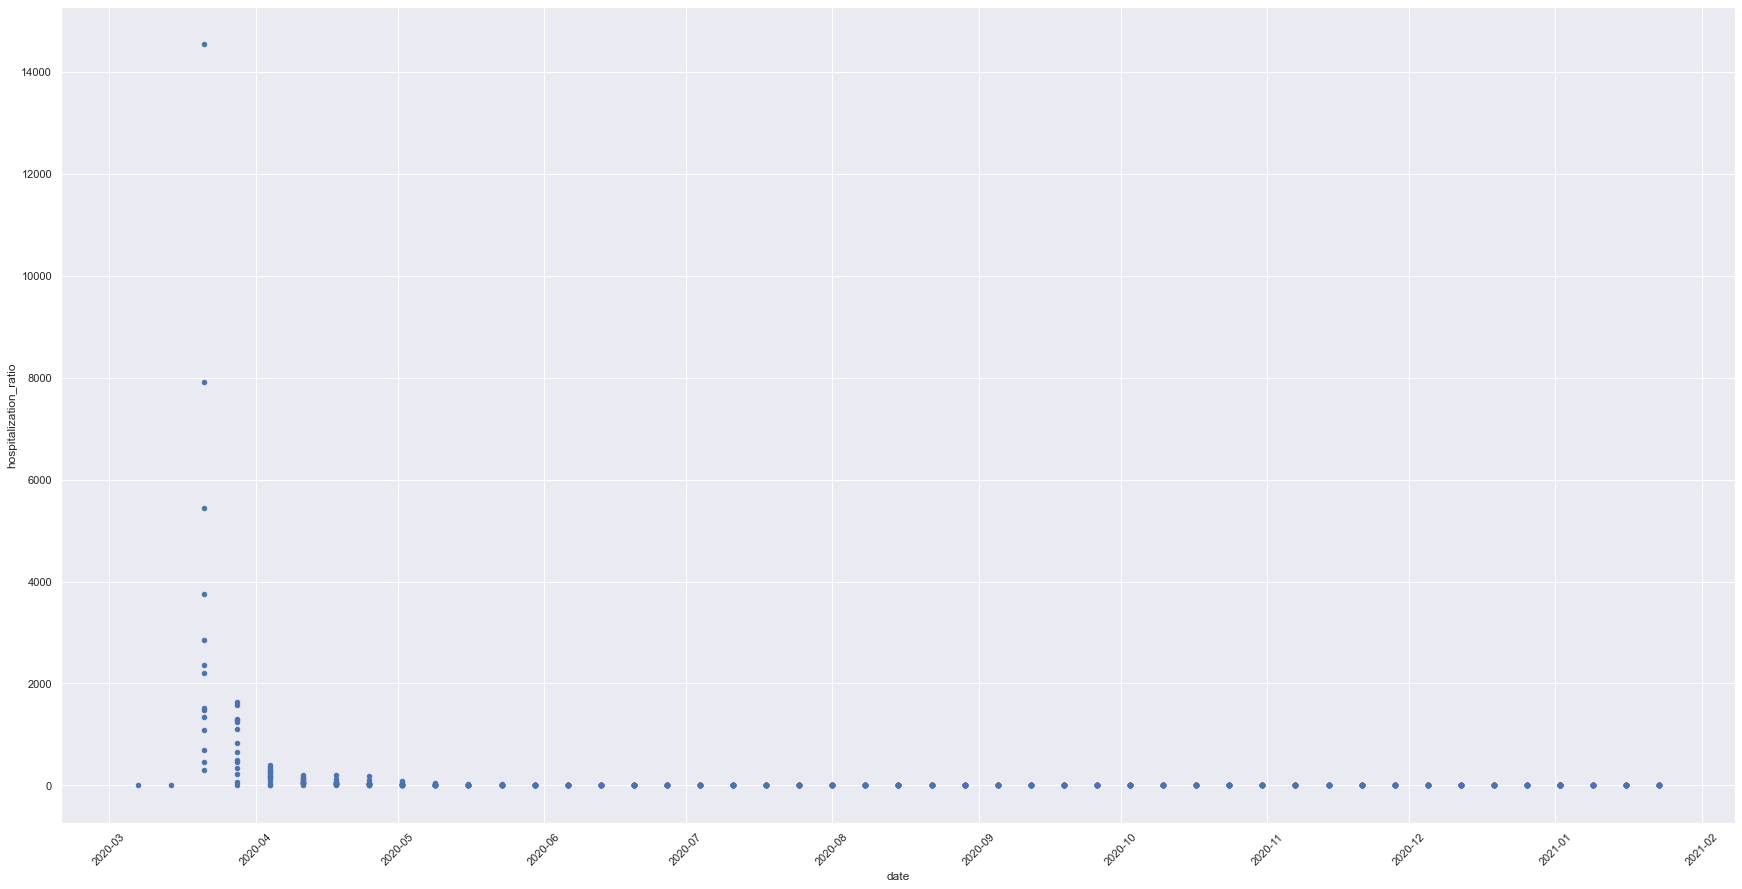

In [632]:
columns = list(combined.columns)
columns.extend(["hospitalization_ratio", "recovery_per_confirmed"])
finalCombined = finalCombined[columns].sort_values("hospitalization_ratio", ascending=False)

finalCombined.plot.scatter(x="date", y="hospitalization_ratio", rot=45)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='date', ylabel='hospitalization_ratio'>

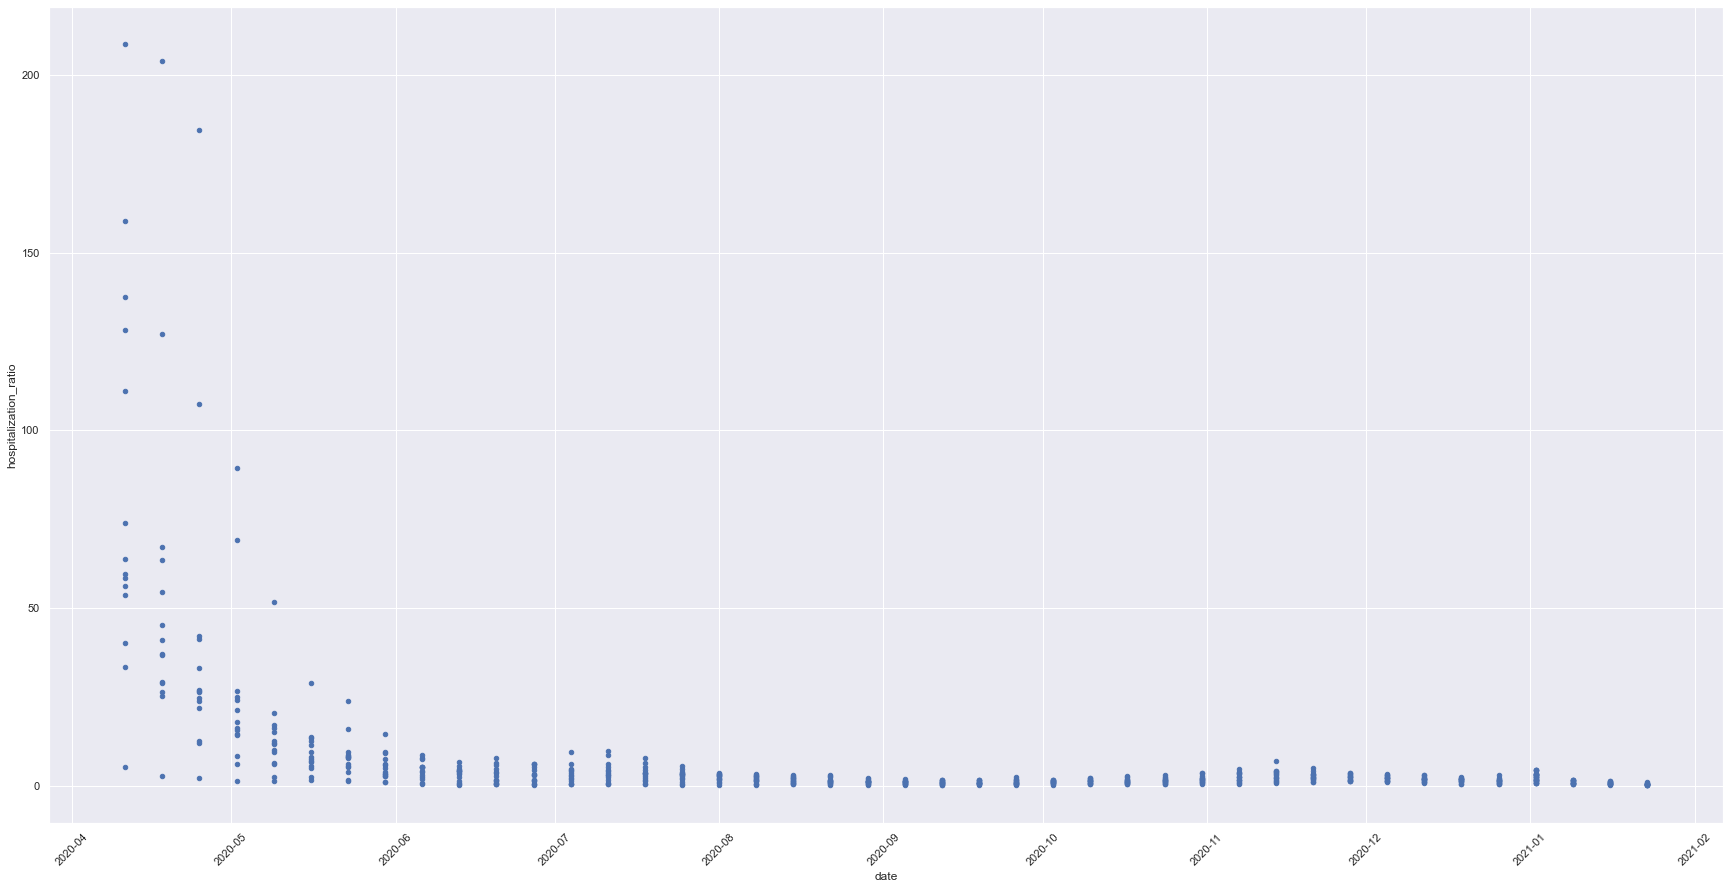

In [633]:
finalCombined[finalCombined["date"] > "04/09/2020"].plot.scatter(x="date", y="hospitalization_ratio", rot=45)

### Yea Humanity just kinda died around March 2020 no cap

### It's quite interesting to see how there was a 14000% hospitalization ratio in March. Maybe no one was ready to collect data when covid happened

In [634]:
finalCombined.head()

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,date,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,recovery_per_confirmed
10,Michigan,IHSP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,115.5,113.8,78.0,0.0,0.0,14540.948192,0.0
7,Georgia,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,268.2,205.6,278.0,4.0,0.0,7920.789551,0.0
6,Connecticut,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,122.6,102.5,67.0,0.0,0.0,5441.688284,0.0
14,Ohio,IHSP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,34.6,28.3,88.0,0.0,0.0,3760.432285,0.0
2,Tennessee,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,72.1,54.3,131.0,0.0,0.0,2854.618979,0.0


## This is for anyone wanting to use this code for some insights!

### Steps:
1. Pick a date range
2. Pick a state or few states
3. Find the weekly rate

In [635]:
print("Here are the available states for study states: %s\n" % finalCombined["catchment"].unique())
print("The date ranges from %s to %s" % (finalCombined["date"].min(), finalCombined["date"].max()))

Here are the available states for study states: ['Michigan' 'Georgia' 'Connecticut' 'Ohio' 'Tennessee' 'Maryland'
 'Colorado' 'Utah' 'California' 'Minnesota' 'Oregon' 'Iowa' 'New York'
 'New Mexico']

The date ranges from 2020-03-07 00:00:00 to 2021-01-23 00:00:00


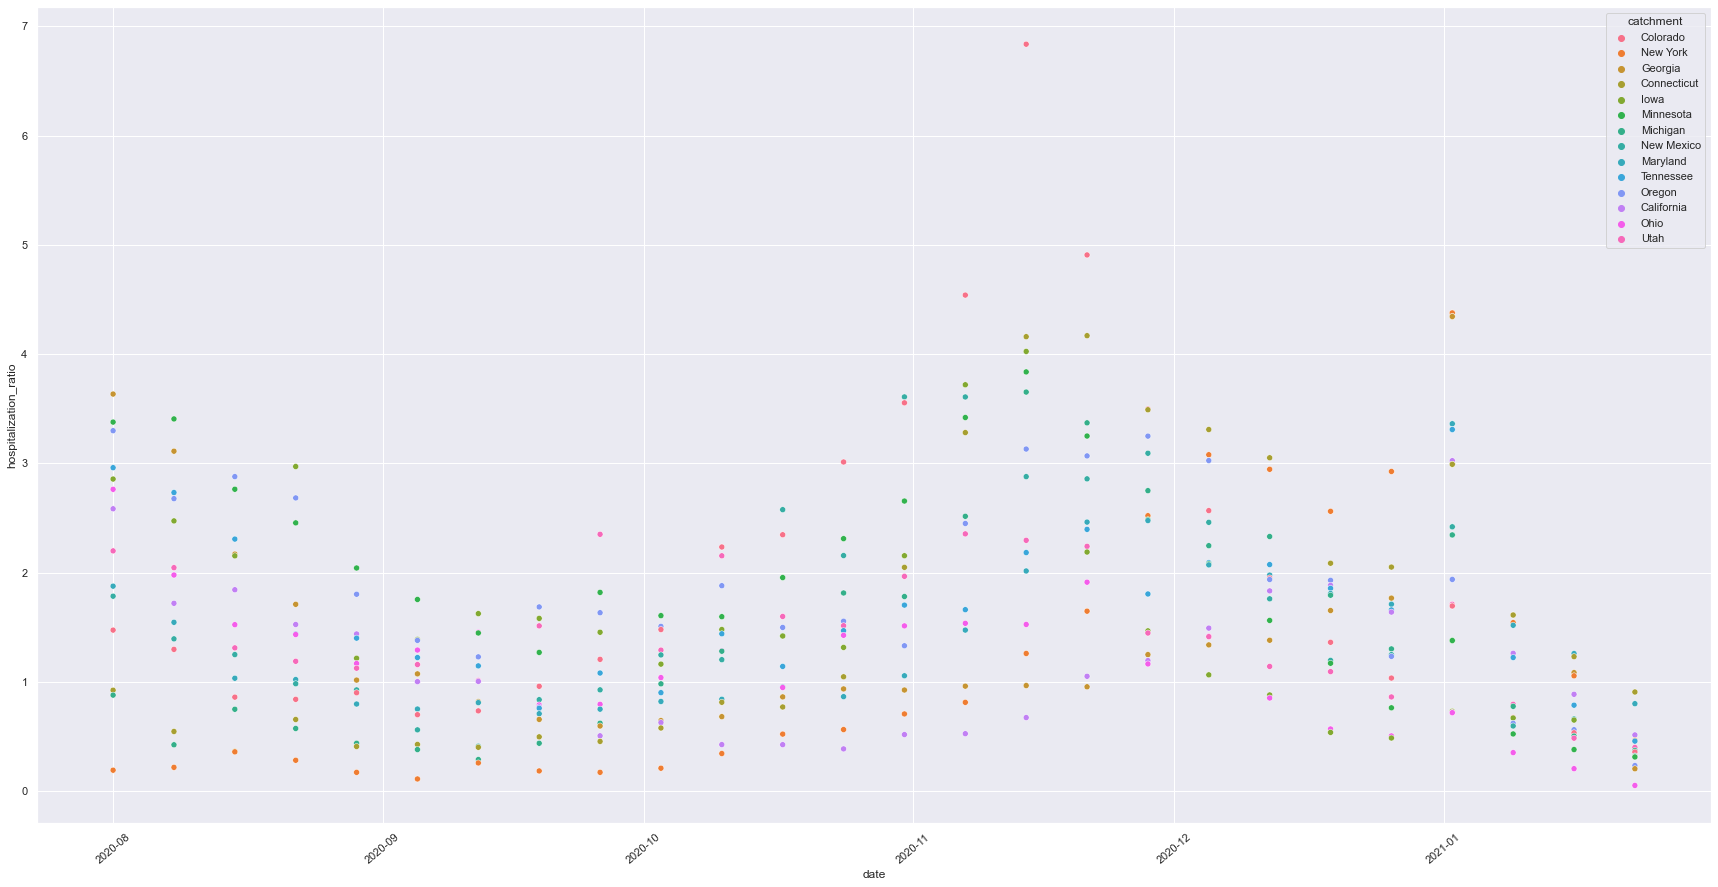

In [636]:
catchments = finalCombined["catchment"].unique()
catchments = "|".join(catchments)

pickARandomState = \
    finalCombined["catchment"].str.contains(catchments) & \
    (finalCombined["date"] >= "2020-08-01") & \
    (finalCombined["date"] <= "2021-01-30")
g = sns.scatterplot(x="date", y="hospitalization_ratio", data=finalCombined[pickARandomState], hue="catchment")
sns.set(rc={'figure.figsize':(30, 15)})
_ = plt.xticks(rotation=40)

## Summary

In [637]:
finalCombined.head()

,catchment,network,year,mmwr_year,mmwr_week,age_category,sex,race,date,cumulative_rate,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,recovery_per_confirmed
10,Michigan,IHSP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,115.5,113.8,78.0,0.0,0.0,14540.948192,0.0
7,Georgia,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,268.2,205.6,278.0,4.0,0.0,7920.789551,0.0
6,Connecticut,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,122.6,102.5,67.0,0.0,0.0,5441.688284,0.0
14,Ohio,IHSP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,34.6,28.3,88.0,0.0,0.0,3760.432285,0.0
2,Tennessee,EIP,2020.0,2020.0,12.0,Overall,Overall,Overall,2020-03-21,72.1,54.3,131.0,0.0,0.0,2854.618979,0.0


In [79]:
finalCombined.describe()

,weekly_rate,Confirmed,Deaths,Recovered,hospitalization_ratio,recovery_per_confirmed
count,658.000000,6.320000e+02,632.000000,632.000000,632.000000,632.000000
mean,245.888450,1.273042e+06,35841.481013,0.080696,102.001634,0.000041
std,243.435358,2.063869e+06,57305.006307,1.249332,747.264409,0.000754
min,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,84.250000,1.688155e+05,3923.750000,0.000000,1.038088,0.000000
50%,165.750000,4.991010e+05,14934.000000,0.000000,2.043753,0.000000
75%,332.800000,1.585826e+06,36946.750000,0.000000,5.204701,0.000000
max,1837.100000,2.016373e+07,282917.000000,28.000000,14540.948192,0.017610


In [638]:
finalCombined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 646 entries, 10 to 0
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   catchment               646 non-null    object        
 1   network                 646 non-null    object        
 2   year                    646 non-null    float64       
 3   mmwr_year               646 non-null    float64       
 4   mmwr_week               646 non-null    float64       
 5   age_category            646 non-null    object        
 6   sex                     646 non-null    object        
 7   race                    646 non-null    object        
 8   date                    646 non-null    datetime64[ns]
 9   cumulative_rate         646 non-null    float64       
 10  weekly_rate             646 non-null    float64       
 11  Confirmed               646 non-null    float64       
 12  Deaths                  646 non-null    float64    

In [639]:
finalCombined.to_csv("./data/merged_data.csv", index=False)

## Have fun :DD